# Comparing observations made before and after a suspicious change in Grid'5000

We have spotted some obvious temperature changes for some nodes of Gros cluster. These changes seem to be caused by a BIOS upgrade. In this notebook, we test if there was more subtile changes on these clusters, e.g. in terms of frequency or performance (it was not clear in the previous plots).

In [1]:
library(lubridate)
library(dplyr)
library(ggplot2)
library(broom)
options(repr.plot.width=10, repr.plot.height=8)
options(mc.cores = 8)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
csv_url = 'https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/raw/master/stats.csv'
changelog_url = 'https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/raw/master/exp_changelog.csv'
csv_monitoring_url = 'https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/raw/master/stats_monitoring.csv'

In [3]:
performance = read.csv(url(csv_url)) %>%
    mutate(cluster = as.factor(cluster), start_time = as_datetime(start_time))
str(performance)

'data.frame':	106229 obs. of  26 variables:
 $ function.          : Factor w/ 1 level "dgemm": 1 1 1 1 1 1 1 1 1 1 ...
 $ cluster            : Factor w/ 10 levels "chetemi","chiclet",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ node               : int  8 8 9 9 1 1 2 2 3 3 ...
 $ cpu                : int  0 1 0 1 0 1 0 1 0 1 ...
 $ jobid              : int  1870101 1870101 1870102 1870102 1870094 1870094 1870095 1870095 1870096 1870096 ...
 $ start_time         : POSIXct, format: "2019-06-14 21:28:39" "2019-06-14 21:28:39" ...
 $ expfile_hash       : Factor w/ 138 levels "07903fe17654a82bcd0b7bb463b7aa9531a0fa4c28cd63c3786e081306f3b8cc",..: 99 99 99 99 99 99 99 99 99 99 ...
 $ avg_gflops         : num  28.9 29.9 29.8 29.8 27.8 ...
 $ intercept          : num  1.70e-06 2.07e-06 1.64e-06 1.77e-06 1.74e-06 ...
 $ intercept_residual : num  2.44e-07 3.92e-07 1.96e-07 5.32e-07 3.73e-07 ...
 $ mk                 : num  1.92e-09 1.80e-09 1.79e-09 1.78e-09 1.92e-09 ...
 $ mk_residual        : num  1.82e-11 2

In [7]:
monitoring = read.csv(url(csv_monitoring_url)) %>%
    mutate(cluster = as.factor(cluster), start_time = as_datetime(start_time))
str(monitoring)

'data.frame':	77857 obs. of  10 variables:
 $ cluster         : Factor w/ 9 levels "chetemi","dahu",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ node            : int  1 1 1 1 2 2 2 2 3 3 ...
 $ cpu             : int  0 1 2 3 0 1 2 3 0 1 ...
 $ jobid           : int  1895522 1895522 1895522 1895522 1895522 1895522 1895522 1895522 1895522 1895522 ...
 $ start_time      : POSIXct, format: "2019-11-24 14:25:10" "2019-11-24 14:25:10" ...
 $ expfile_hash    : Factor w/ 74 levels "07903fe17654a82bcd0b7bb463b7aa9531a0fa4c28cd63c3786e081306f3b8cc",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ mean_frequency  : num  2.12 2.22 2.2 2.35 2.17 ...
 $ mean_temperature: num  81.8 76.9 68.7 67.3 81.2 ...
 $ std_frequency   : num  0.0284 0.0383 0.0396 0.0384 0.0337 ...
 $ std_temperature : num  1.61 1.69 1.04 1.22 2.11 ...


In [5]:
changelog = read.csv(url(changelog_url)) %>%
    mutate(date=as_datetime(date))
changelog

date,cluster,node,type,description
<dttm>,<fct>,<fct>,<fct>,<fct>
2019-07-13,all,all,protocol,randomisation of the expfile
2019-09-01,dahu,13/14/15/16,G5K,cooling issue
2019-10-18,all,all,protocol,randomisation of the matrices content
2019-11-27,dahu,13/14/15/16,G5K,cooling issue fixed
2020-02-06,gros,all,G5K,BIOS upgrade
2020-04-01,dahu,all,G5K,BIOS upgrade
2020-05-05,all,all,protocol,stop randomisation of the expfile
2020-05-18,dahu,26,G5K,power drain
2020-05-21,ecotype,24,G5K,unexplained


There was (according to the changelog) an important change on 2020-06-19 on the nodes of gros. Let's remove all the measures made before this date.

In [8]:
performance_recent = performance %>% filter(start_time > as_datetime('2020-06-19'))
monitoring_recent  = monitoring  %>% filter(start_time > as_datetime('2020-06-19'))

## Utility function

Let's define a function for our tests. It takes as input the whole dataframe, the name of the cluster, the date of the possible change, the column to test on and the level of confidence. It outputs the number of CPUs for which the T-test reveals a significant change (with the given level of confidence) and then shows the plot of the averages and confidence intervals (with also the given level of confidence).

In the following, I define my own `confidence_interval` function for the plot, as the package `Hmisc` was not available for my version of R, so I could not use the usual `mean_cl_boot` in `stat_summary`.

In [9]:
confidence_interval <- function(vector, interval) { # Adapted from https://stackoverflow.com/a/48612236/4110059
    # Standard deviation of sample
    vec_sd <- sd(vector)
    # Sample size
    n <- length(vector)
    # Mean of sample
    vec_mean <- mean(vector)
    # Error according to t distribution
    error <- qt((interval + 1)/2, df = n - 1) * vec_sd / sqrt(n)
    # Confidence interval as a vector
    result <- c("ymin" = vec_mean - error, "y" = vec_mean, "ymax" = vec_mean + error)
    return(result)
}

test_changes = function(df, test_cluster, change_date, test_column, confidence=0.95) {
    # First, some reformating and filtering
    df = df %>%
        filter(cluster==test_cluster) %>%
        mutate(new = start_time > as_datetime(change_date))
    df[['test_col']] = df[[test_column]]  # creating an alias, for using formulas afterward

    # Then, we apply a test
    test_result = df %>% group_by(node, cpu) %>% do(tidy(t.test(test_col~new, data=.)))
    nb_changes = (test_result %>% filter(p.value < 1-confidence) %>% ungroup() %>% count())[[1]]  # https://stats.stackexchange.com/a/168420/196336
    print(paste('There was ', nb_changes, ' CPUs with a significant change (P-value below ', 1-confidence, ')', sep=''))
    
    # Finally, we draw a plot
    title = paste(test_column, ' on ', test_cluster, ' before and after ', change_date, ' with a ', confidence*100, '% interval', sep='')
    plot = ggplot(df) +
        aes(x=interaction(cpu, node), y=test_col, group=new, color=new) +
        stat_summary(fun.data = (function(vec) confidence_interval(vec, confidence))) +
        ylab(test_column) +
        xlab('CPU - NODE') +
        labs(color=paste('After', change_date)) +
        ggtitle(paste()) +
        theme_light() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        ggtitle(title)
    return(plot)
}

In [24]:
performance_recent %>% dplyr::filter(start_time > as_datetime('2020-10-01')) %>% dplyr::filter(node == 100, cluster == "gros") %>% count()

n
<int>
3


## Possible change on Gros

Similarly, there has been a BIOS upgrade on Gros on 2020-10-01. The plots show a clear temperature drop on all the nodes, but nothing obvious for the performance and the frequency. Let's check this out.

[1] "There was 81 CPUs with a significant change (P-value below 0.05)"


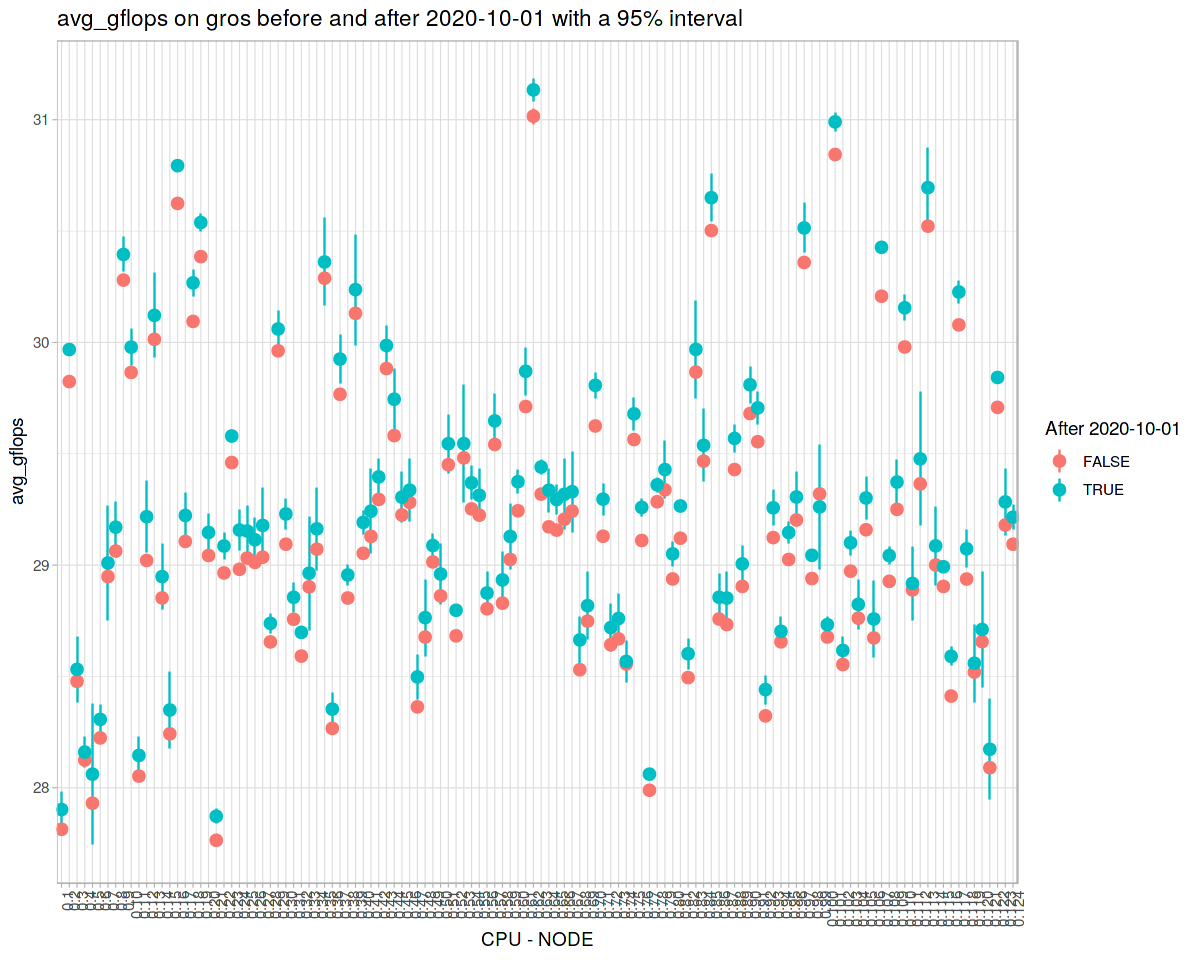

In [26]:
test_changes(performance_recent, 'gros', '2020-10-01', 'avg_gflops', 0.95)

[1] "There was 36 CPUs with a significant change (P-value below 0.05)"


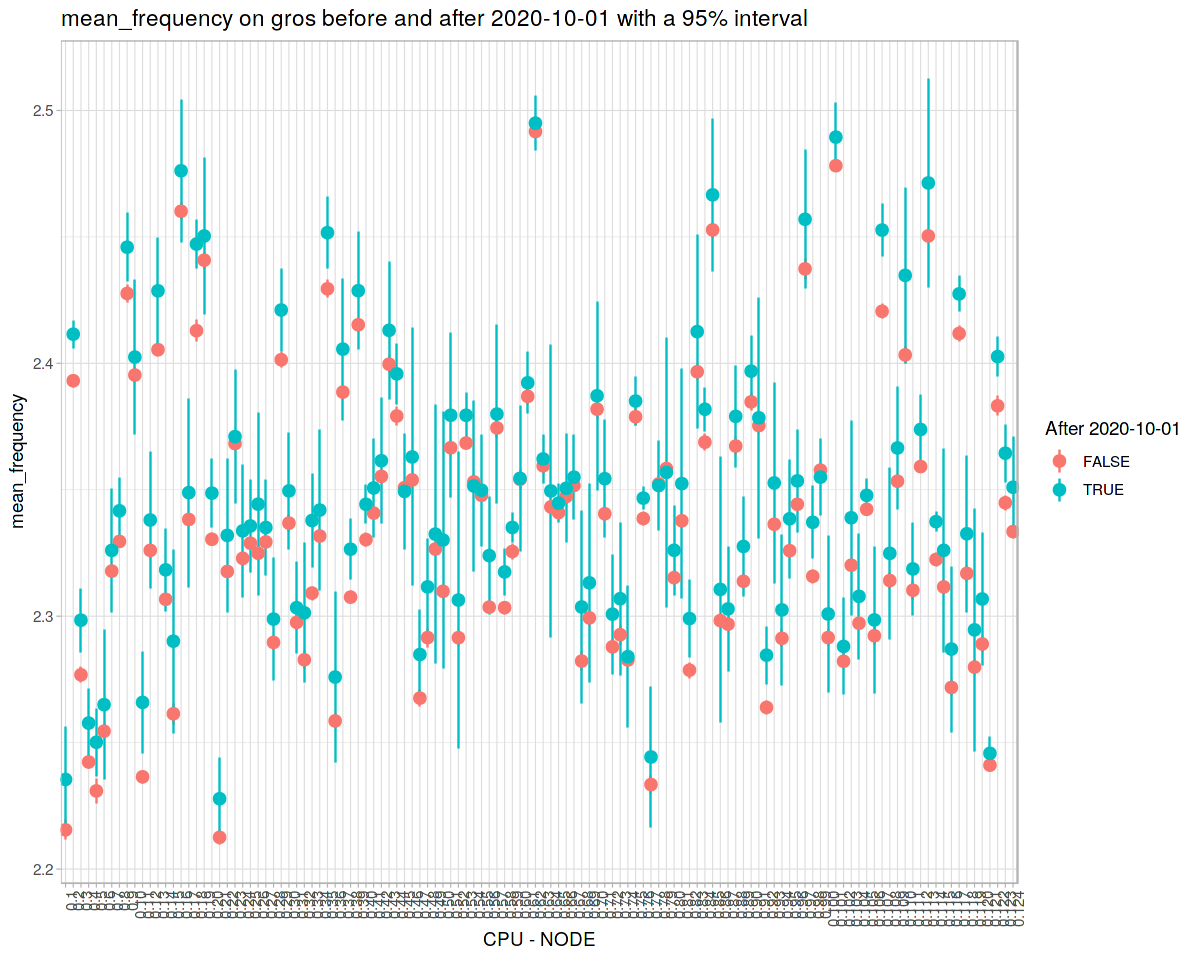

In [28]:
test_changes(monitoring_recent, 'gros', '2020-10-01', 'mean_frequency', 0.95)

[1] "There was 25 CPUs with a significant change (P-value below 0.05)"


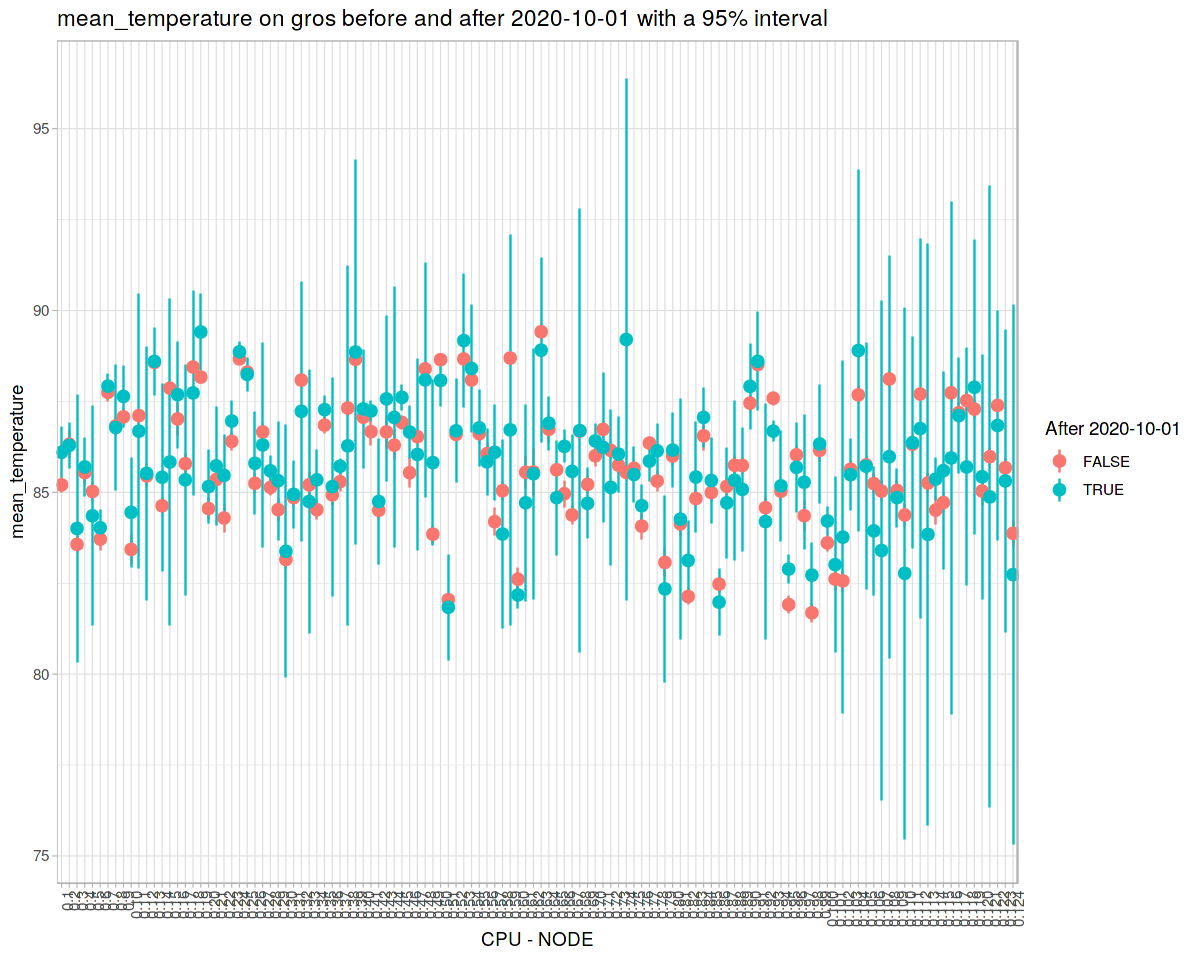

In [30]:
test_changes(monitoring_recent, 'gros', '2020-10-01', 'mean_temperature', 0.95)